In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
f1 = pd.read_csv('data/f1_master.csv')

In [38]:
f1.tail(20)

,position,driverNumber,driverId,constructorId,engineManufacturerId,tyreManufacturerId,laps,time,timePenalty,gap,...,fp3_position,fp3_gap,qual_position,qual_gap,q1,q2,q3,fastest_lap,driver_of_the_day,grandSlam
4202,1,4,lando-norris,mclaren,mercedes,pirelli,58.0,1:26:33.291,NaN,+0.000,...,2.0,0.193,1,0.000,1:23.682,1:23.098,1:22.595,0,0,NaN
4203,2,55,carlos-sainz-jr,ferrari,ferrari,pirelli,58.0,1:26:39.123,NaN,+5.832,...,5.0,0.438,3,0.229,1:23.487,1:22.985,1:22.824,0,0,NaN
4204,3,16,charles-leclerc,ferrari,ferrari,pirelli,58.0,1:27:05.219,NaN,+31.928,...,9.0,0.665,14,NaN,1:23.302,1:23.833,NaN,0,0,NaN
4205,4,44,lewis-hamilton,mercedes,mercedes,pirelli,58.0,1:27:09.774,NaN,+36.483,...,3.0,0.390,18,NaN,1:23.887,NaN,NaN,0,0,NaN
4206,5,63,george-russell,mercedes,mercedes,pirelli,58.0,1:27:10.829,NaN,+37.538,...,6.0,0.642,7,0.537,1:23.678,1:23.283,1:23.132,0,0,NaN
4207,6,1,max-verstappen,red-bull,honda-rbpt,pirelli,58.0,1:27:23.138,NaN,+49.847,...,4.0,0.411,5,0.350,1:23.516,1:22.998,1:22.945,0,0,NaN
4208,7,10,pierre-gasly,alpine,renault,pirelli,58.0,1:27:45.851,NaN,+1:12.560,...,13.0,0.975,6,0.389,1:23.548,1:23.086,1:22.984,0,0,NaN
4209,8,27,nico-hulkenberg,haas,ferrari,pirelli,58.0,1:27:48.845,NaN,+1:15.554,...,7.0,0.660,4,0.291,1:23.722,1:23.040,1:22.886,0,0,NaN
4210,9,14,fernando-alonso,aston-martin,mercedes,pirelli,58.0,1:27:55.664,NaN,+1:22.373,...,15.0,1.020,8,0.601,1:23.794,1:23.268,1:23.196,0,0,NaN
4211,10,81,oscar-piastri,mclaren,mercedes,pirelli,58.0,1:27:57.112,NaN,+1:23.821,...,1.0,0.000,2,0.209,1:23.640,1:23.199,1:22.804,0,0,NaN


In [39]:
# drop all irrellevant columns
f1.drop(['driverNumber','engineManufacturerId','tyreManufacturerId','laps','time','timePenalty','interval','points',
        'grandSlam', 'reasonRetired','qual_gap'], axis=1, inplace=True)


In [40]:
# drop all drivers with less than 5 appearances
driver_counts = f1['driverId'].value_counts()
drivers_to_keep = driver_counts[driver_counts >= 5].index

f1 = f1[f1['driverId'].isin(drivers_to_keep)]

In [41]:
# drop all circuits with less than 3 appearances
circuit_counts = f1['circuitId'].value_counts()
circuits_to_keep = circuit_counts[circuit_counts >= 3].index

f1 = f1[f1['circuitId'].isin(circuits_to_keep)]

In [42]:
# go through the columns one by one
# 0. Position

# replace all verions of not finishing with 'DNF'
f1['position'] = f1['position'].replace(['DNS','DSQ','DNP'], 'DNF')

# modern f1 only has 20 racers, despite more in past years. For simiplicity, make 20 the maximum
f1['position'] = f1['position'].replace(['21','22'], '20')

# create a column that has position as a numerical value
f1['position_num'] = pd.to_numeric(f1['position'], errors='coerce')

In [43]:
# 1. driverId
# use only driver's last name
def get_last_name(full_name):
    # last name comes after the last '-'
    last_name = full_name.split('-')[-1]
    if(last_name == 'jr'):
        last_name = full_name.split('-')[-2]
    return last_name

driver_full_names = f1['driverId'].unique()
driver_last_names = []
for i in range(len(driver_full_names)):
    driver_last_names.append(get_last_name(driver_full_names[i]))

driver_dict = dict(zip(driver_full_names, driver_last_names))
f1['driverId'] = f1['driverId'].map(driver_dict)

In [44]:
# 3. gap
# convert this to numeric
f1['gap'] = pd.to_numeric(f1['gap'].str[1:], errors='coerce')
max_gap = f1['gap'].max()
f1['gap'] = f1['gap'].fillna(max_gap)

In [45]:
# 4. gridPosition
# make the maximum gridPosition 20. Change all pit lane starts to 20
f1['gridPosition'] = pd.to_numeric(f1['gridPosition'].replace(['21', '22', 'PL'], 20))

In [46]:
# 8. fp1/2/3_position
f1['fp1_position'] = f1['fp1_position'].replace([21, 22], 20)
f1['fp2_position'] = f1['fp2_position'].replace([21, 22], 20)
f1['fp3_position'] = f1['fp3_position'].replace([21, 22], 20)

In [47]:
# 14. qual_position
f1['qual_position'] = pd.to_numeric(f1['qual_position'], errors='coerce')
f1['qual_position'] = f1['qual_position'].replace([21, 22], 20)

In [48]:
# convert the qualifing times into floats
def timestring2seconds(timestring):
    try:
        nums = timestring.split(':')
        return float(nums[0])*60 + float(nums[1])
    except:
        return timestring

for q in ['q1','q2','q3']:
    f1[q] = f1[q].apply(timestring2seconds)
    f1[q] = pd.to_numeric(f1[q], errors='coerce')

In [49]:
# for each qualifying round, convert each qualifying time to a delta to the fastest driver that round
years = f1['year'].unique()

for year in years:
    f1_sub = f1[f1['year'] == year]
    rounds = f1_sub['round'].unique()
    for round_num in rounds:
        f1_round = f1_sub[f1_sub['round'] == round_num]
        try:
            q1_min = np.nanmin(f1_round['q1'])
            q2_min = np.nanmin(f1_round['q2'])
            q3_min = np.nanmin(f1_round['q3'])
        except:
            pass
        
        mask = (f1['year'] == year) & (f1['round'] == round_num)
        mask1 = mask & (f1['q1'] != np.nan)
        f1.loc[mask, 'q1'] -= q1_min
        f1.loc[mask, 'q2'] -= q2_min
        f1.loc[mask, 'q3'] -= q3_min
        
    ### END loop through rounds
### END loop through years

# replace outliers
for q in ['q1','q2','q3','fp1_gap','fp2_gap','fp3_gap']:
    mean = f1[q].mean()
    std_dev = f1[q].std()

    # Define the threshold for outliers
    threshold = mean + 3 * std_dev

    # Replace outliers with the threshold value
    f1[q] = f1[q].apply(lambda x: threshold if x > threshold else x)

        

C:\Users\Drew\AppData\Local\Temp\ipykernel_13844\3024295951.py:12: RuntimeWarning: All-NaN axis encountered
  q3_min = np.nanmin(f1_round['q3'])


In [50]:
f1.tail(20)

,position,driverId,constructorId,gap,gridPosition,round,year,circuitId,fp1_position,fp1_gap,...,fp2_gap,fp3_position,fp3_gap,qual_position,q1,q2,q3,fastest_lap,driver_of_the_day,position_num
4201,DNF,ocon,alpine,59.978,20.0,23,2024,qatar,20.0,2.327,...,NaN,NaN,NaN,20.0,1.473,NaN,NaN,0,0,NaN
4202,1,norris,mclaren,0.000,1.0,24,2024,abu-dhabi,2.0,0.221,...,0.000,2.0,0.193,1.0,0.380,0.113,0.000,0,0,1.0
4203,2,sainz,ferrari,5.832,3.0,24,2024,abu-dhabi,NaN,NaN,...,0.582,5.0,0.438,3.0,0.185,0.000,0.229,0,0,2.0
4204,3,leclerc,ferrari,31.928,19.0,24,2024,abu-dhabi,1.0,0.000,...,0.684,9.0,0.665,14.0,0.000,0.848,NaN,0,0,3.0
4205,4,hamilton,mercedes,36.483,16.0,24,2024,abu-dhabi,3.0,0.485,...,0.602,3.0,0.390,18.0,0.585,NaN,NaN,0,0,4.0
4206,5,russell,mercedes,37.538,6.0,24,2024,abu-dhabi,4.0,0.844,...,1.017,6.0,0.642,7.0,0.376,0.298,0.537,0,0,5.0
4207,6,verstappen,red-bull,49.847,4.0,24,2024,abu-dhabi,NaN,NaN,...,1.081,4.0,0.411,5.0,0.214,0.013,0.350,0,0,6.0
4208,7,gasly,alpine,59.978,5.0,24,2024,abu-dhabi,5.0,1.012,...,1.000,13.0,0.975,6.0,0.246,0.101,0.389,0,0,7.0
4209,8,hulkenberg,haas,59.978,7.0,24,2024,abu-dhabi,6.0,1.052,...,0.462,7.0,0.660,4.0,0.420,0.055,0.291,0,0,8.0
4210,9,alonso,aston-martin,59.978,8.0,24,2024,abu-dhabi,11.0,1.183,...,1.057,15.0,1.020,8.0,0.492,0.283,0.601,0,0,9.0


## 2. EDA on the Cleaned Dataset

In [51]:
# how many null values are there
f1.isna().sum()

position                0
driverId                0
constructorId           0
gap                     0
gridPosition           12
round                   0
year                    0
circuitId               0
fp1_position          211
fp1_gap               318
fp2_position          376
fp2_gap               424
fp3_position          445
fp3_gap               520
qual_position          78
q1                     58
q2                   1118
q3                   2183
fastest_lap             0
driver_of_the_day       0
position_num          631
dtype: int64

Most of the null data is coming from drivers not qualifying for q2 or q3. Given half of the drivers don't make it to q3, we're potentially missing out on half the dataset for modeling approaches that require no missing values.

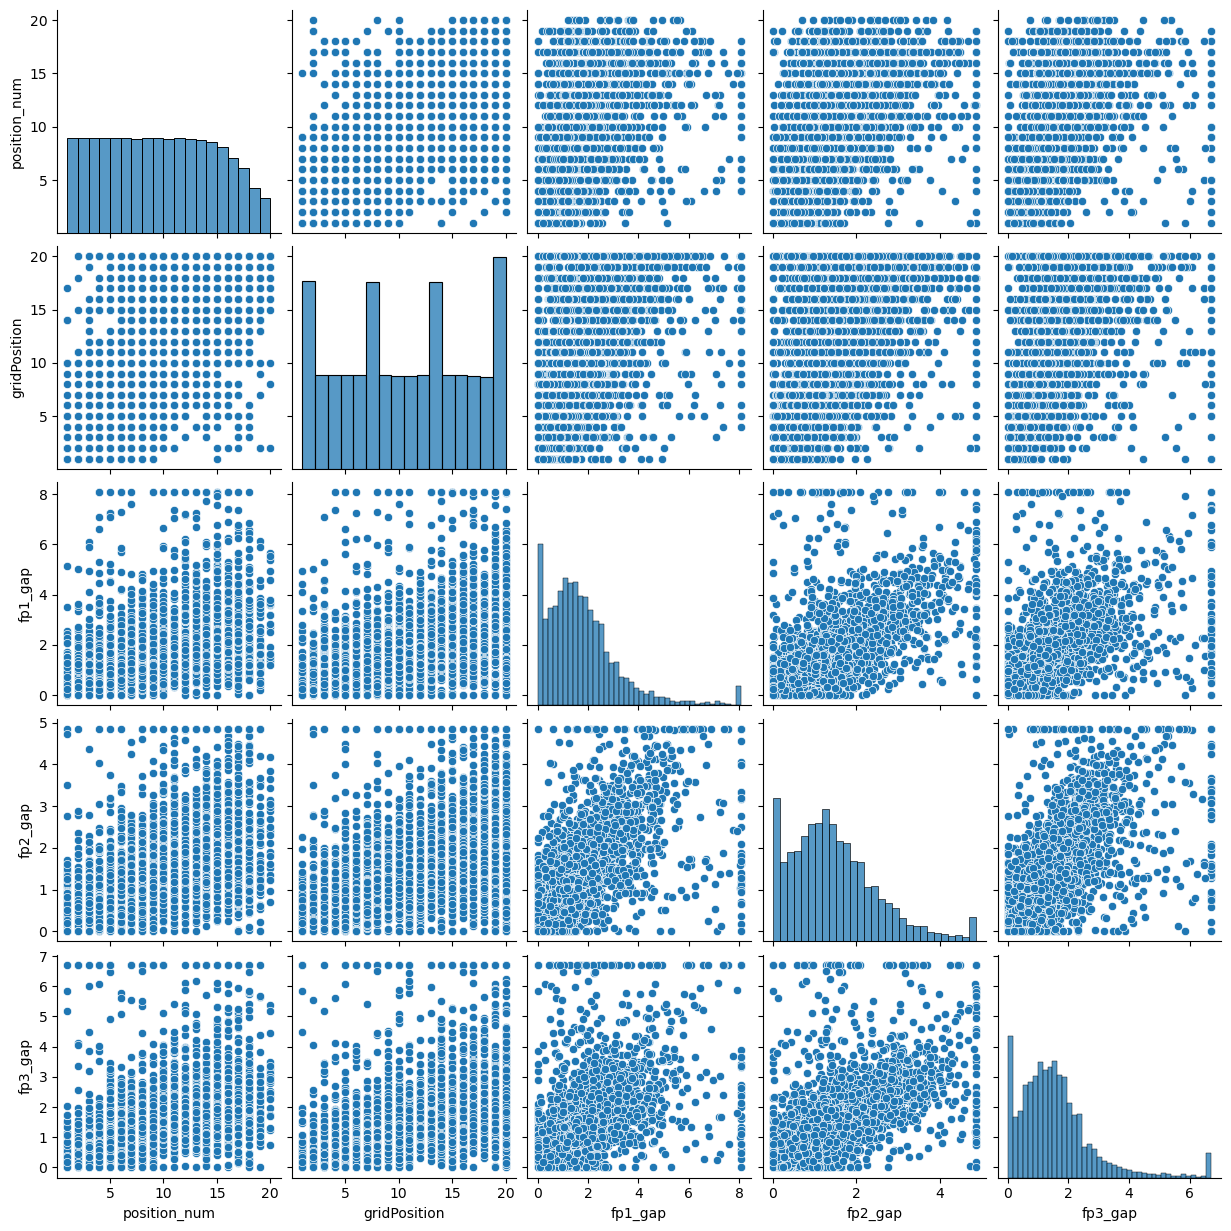

In [52]:
# plot the correlation for some potential predictors
sns.pairplot(f1[['position_num','gridPosition','fp1_gap','fp2_gap','fp3_gap']])

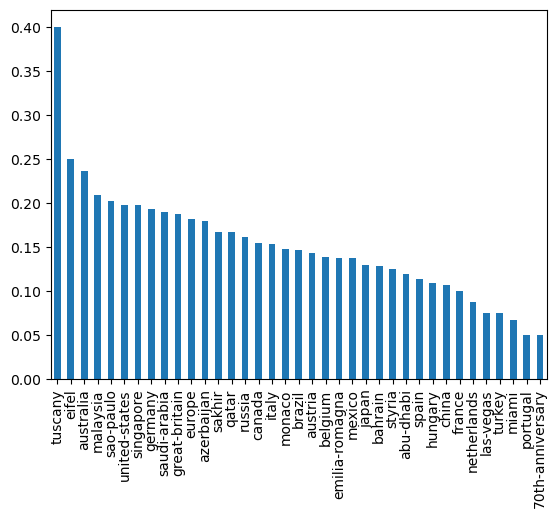

In [53]:
# which tracks have the most DNF's
circuit_counts = f1['circuitId'].value_counts()
circuit_dnf_counts = f1[f1['position'] == 'DNF']['circuitId'].value_counts()

circuit_dnf = pd.DataFrame({'circuit_counts': circuit_counts, 'dnf_counts': circuit_dnf_counts})
circuit_dnf['dnf_percent'] = circuit_dnf['dnf_counts']/circuit_dnf['circuit_counts']
circuit_dnf.sort_values(by='dnf_percent',ascending=False,inplace=True)

circuit_dnf['dnf_percent'].plot(kind='bar')

# pull out the 'dangerous_circuits'
risk_threshold = circuit_dnf['dnf_percent'].quantile(0.70)
circuit_dnf['risky_circuit'] = np.where(circuit_dnf['dnf_percent'] >= risk_threshold, 1, 0)
# add to the master dataframe
risk_dict = circuit_dnf['risky_circuit'].to_dict()
f1['risky_circuit'] = f1['circuitId'].map(risk_dict)

In [54]:
# add a specific DNF column
f1['dnf'] = np.where(f1['position'] == 'DNF', 1, 0)

f1['positions_gained'] = f1['qual_position'] - f1['position_num']

In [55]:
# add fantasy points
points_map = {'1': 25, '2': 18, '3': 15, '4': 12, '5': 10,
              '6': 8, '7': 6, '8': 4, '9': 2, '10': 1,
              '11': 0,'12': 0,'13': 0,'14': 0,'15': 0,
              '16': 0,'17': 0,'18': 0,'19': 0,'20': 0, 'DNF': 0}
    
qual_map = {1:10, 2:9, 3:8, 4:7, 5:6, 6:5, 7:4, 8:3, 9:2, 10:1,
            11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0}
    
driver_of_the_day_bonus = 10
fastest_lap_bonus = 10
# without data on number of overtakes, overtakes is approximated by some fraction of the places gained
overtake_ratio = 0.76
qual_dnf_penalty = -5
dnf_penalty = -20
    
def get_fantasy_points(drive):
    try:
        total_points = qual_map[drive['qual_position']]
    except:
        total_points = qual_dnf_penalty
    
    total_points += points_map[drive['position']]
    
    if(not np.isnan(drive['positions_gained'])):
        total_points += drive['positions_gained']
        if(drive['positions_gained'] > 0):
            total_points += math.ceil(drive['positions_gained']*overtake_ratio)

    
    # fastest lap
    total_points += drive['fastest_lap']*fastest_lap_bonus
    
    # driver of the day
    total_points += drive['driver_of_the_day']*driver_of_the_day_bonus
    
    # DNF penalty
    total_points += drive['dnf']*dnf_penalty
    
    return total_points
### END get_fantasy_points()

f1['fantasy_points'] = f1.apply(get_fantasy_points, axis=1)
    

Mean fantasy points:  7.937826293308021
Median fantasy points:  7.0
Std fantasy points:  16.426227851404725


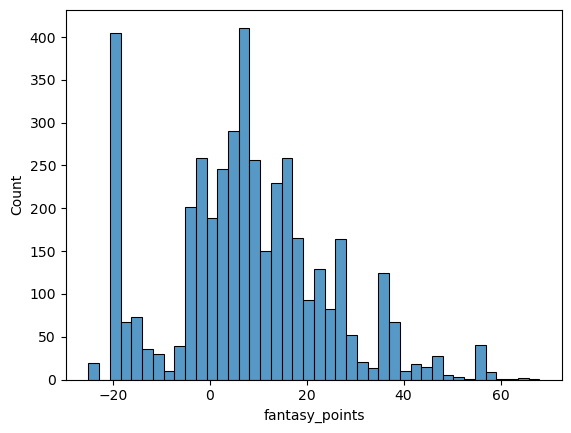

In [56]:
print('Mean fantasy points: ', f1['fantasy_points'].mean())
print('Median fantasy points: ', f1['fantasy_points'].median())
print('Std fantasy points: ', f1['fantasy_points'].std())

sns.histplot(f1['fantasy_points'])
plt.show()

Histogram of fantasy points show distribution is skewed right with mean about 0.9 points higher than the median. There is an additional cluster around the -20 pt mark, due to the large penalty for a dnf.

In [106]:
def add_N_previous_races(f1_in, N=1):
    # add the results of the driver's previous N races
    f1_out = f1_in.copy()
    
    for i in range(1, N+1):
        f1_out['position_minus'+str(i)] = np.nan
        f1_out['fantasy_points_minus'+str(i)] = np.nan
        
    for i in range(len(f1_out)):
        current_driver = f1_in.iloc[i]['driverId']
        
        if(i==0):
            continue
        
        f1_sub = f1_out[:i] # get rows before the current row
        f1_sub = f1_sub[f1_sub['driverId'] == current_driver]
        f1_sub.reset_index(drop=True, inplace=True)
        
        if(f1_sub.empty):
            # no previous races
            continue
        
        for j in range(1, N+1):
            if(j<=len(f1_sub)):
                f1_out.loc[i, 'position_minus'+str(j)] = f1_sub.iloc[-j]['position_num']
                f1_out.loc[i, 'fantasy_points_minus'+str(j)] = f1_sub.iloc[-j]['fantasy_points']
            
        ### END loop through previous races
        
    ### END loop through each driver
    
    return f1_out

In [103]:
f1.reset_index(drop=True, inplace=True)

In [110]:
f1 = add_N_previous_races(f1, 5)

In [111]:
# save the cleaned dataset
f1.to_csv('data/f1_master_cleaned.csv', index=False)

The next sections dig deeper into understanding relationship between grid position and race place.

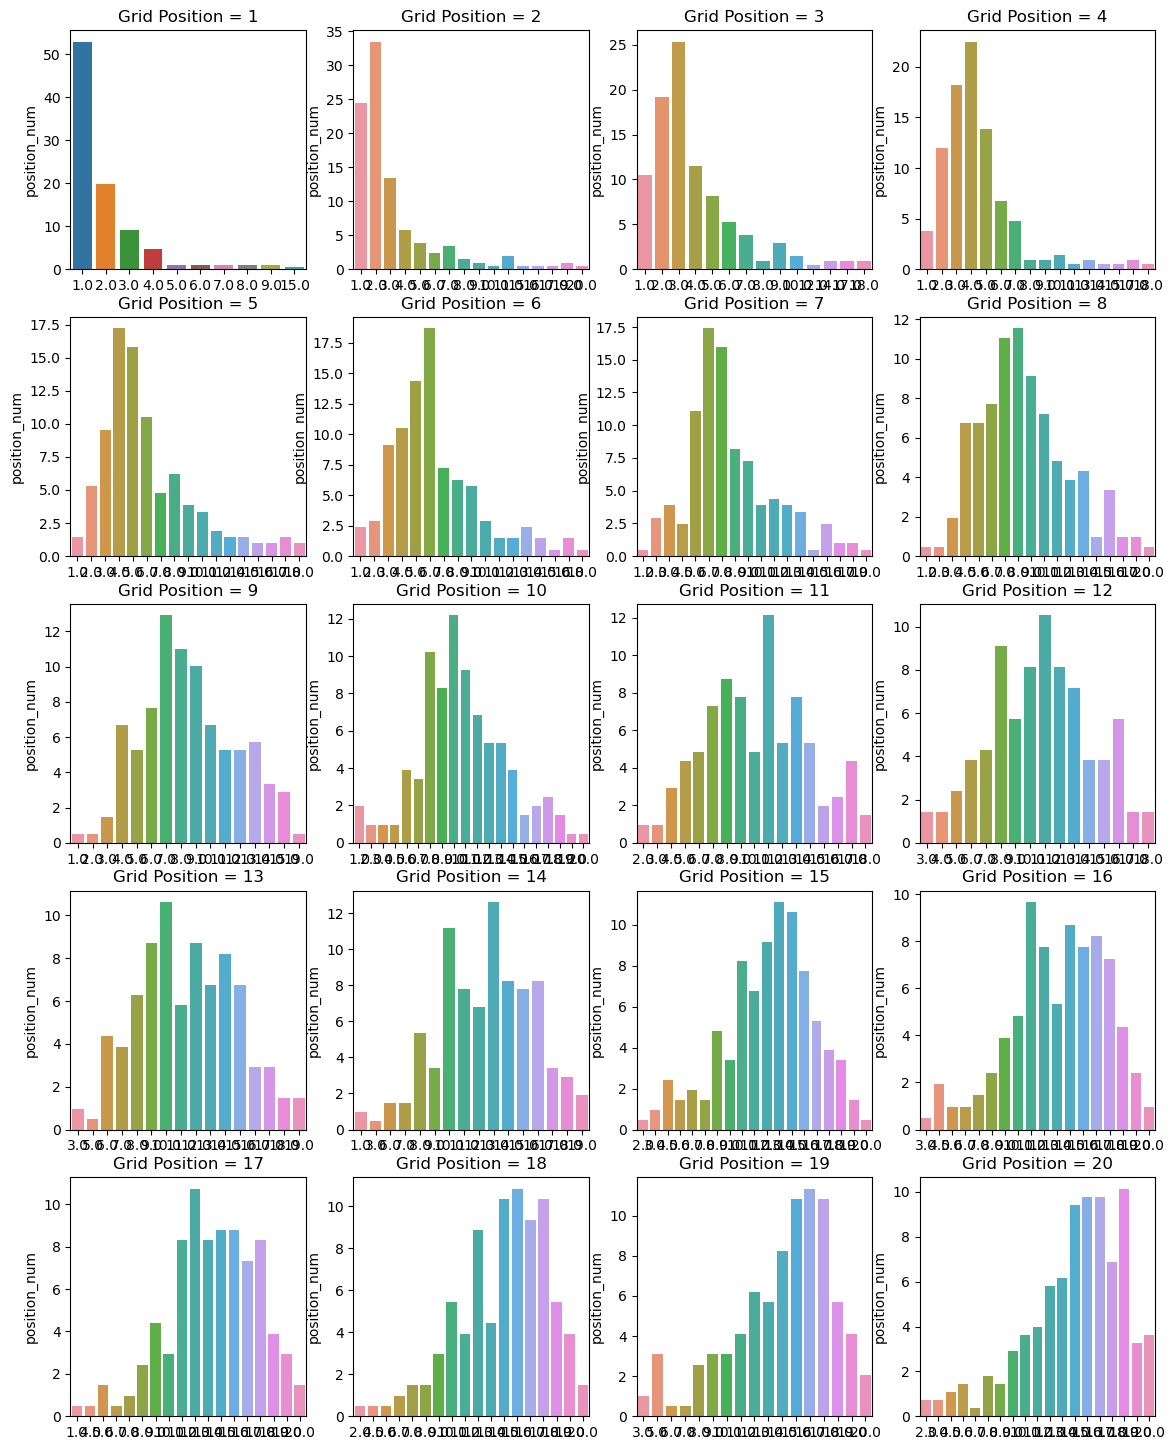

In [26]:
grid_positions = range(1, 21)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 18), squeeze=False) 
axes = axes.flatten()

for grid_pos in grid_positions:
    race_counts = f1[f1['gridPosition'] == grid_pos]['position_num'].value_counts(normalize=True, dropna=False)
    sns.barplot(x=race_counts.index, y=race_counts*100, ax=axes[grid_pos-1])
    #axes[grid_pos-1].set_xlabel('Race Place')
    axes[grid_pos-1].set_title('Grid Position = ' + str(grid_pos))
plt.show()

Let's fit a beta distribution to each starting grid position.

In [27]:
from scipy.stats import beta

In [31]:
grid_positions = range(1, 21)
a_list = []
b_list = []
scale_list = []

for grid_pos in grid_positions:
    race_counts = f1[f1['gridPosition'] == grid_pos]['position_num'].dropna()
    if grid_pos == 1:
        race_counts = race_counts[race_counts <= 16]
    a, b, loc, scale = beta.fit(race_counts, floc=1)
    a_list.append(a)
    if grid_pos == 1:
        b_list.append(b*2)
    else:
        b_list.append(b)
    scale_list.append(scale)


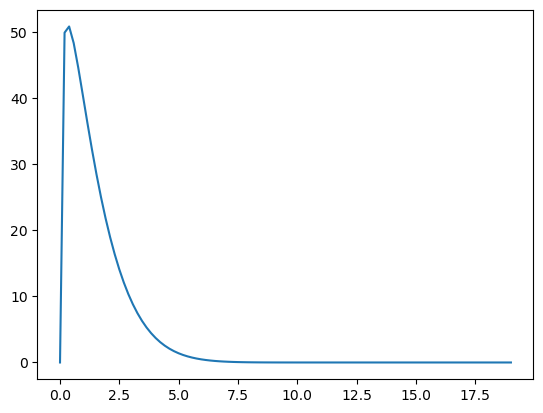

In [32]:
x = np.linspace(1, 20, 100)
y = beta.pdf(x, a_list[0], b_list[0], 1, scale_list[0])
plt.plot(x-1, y*100)

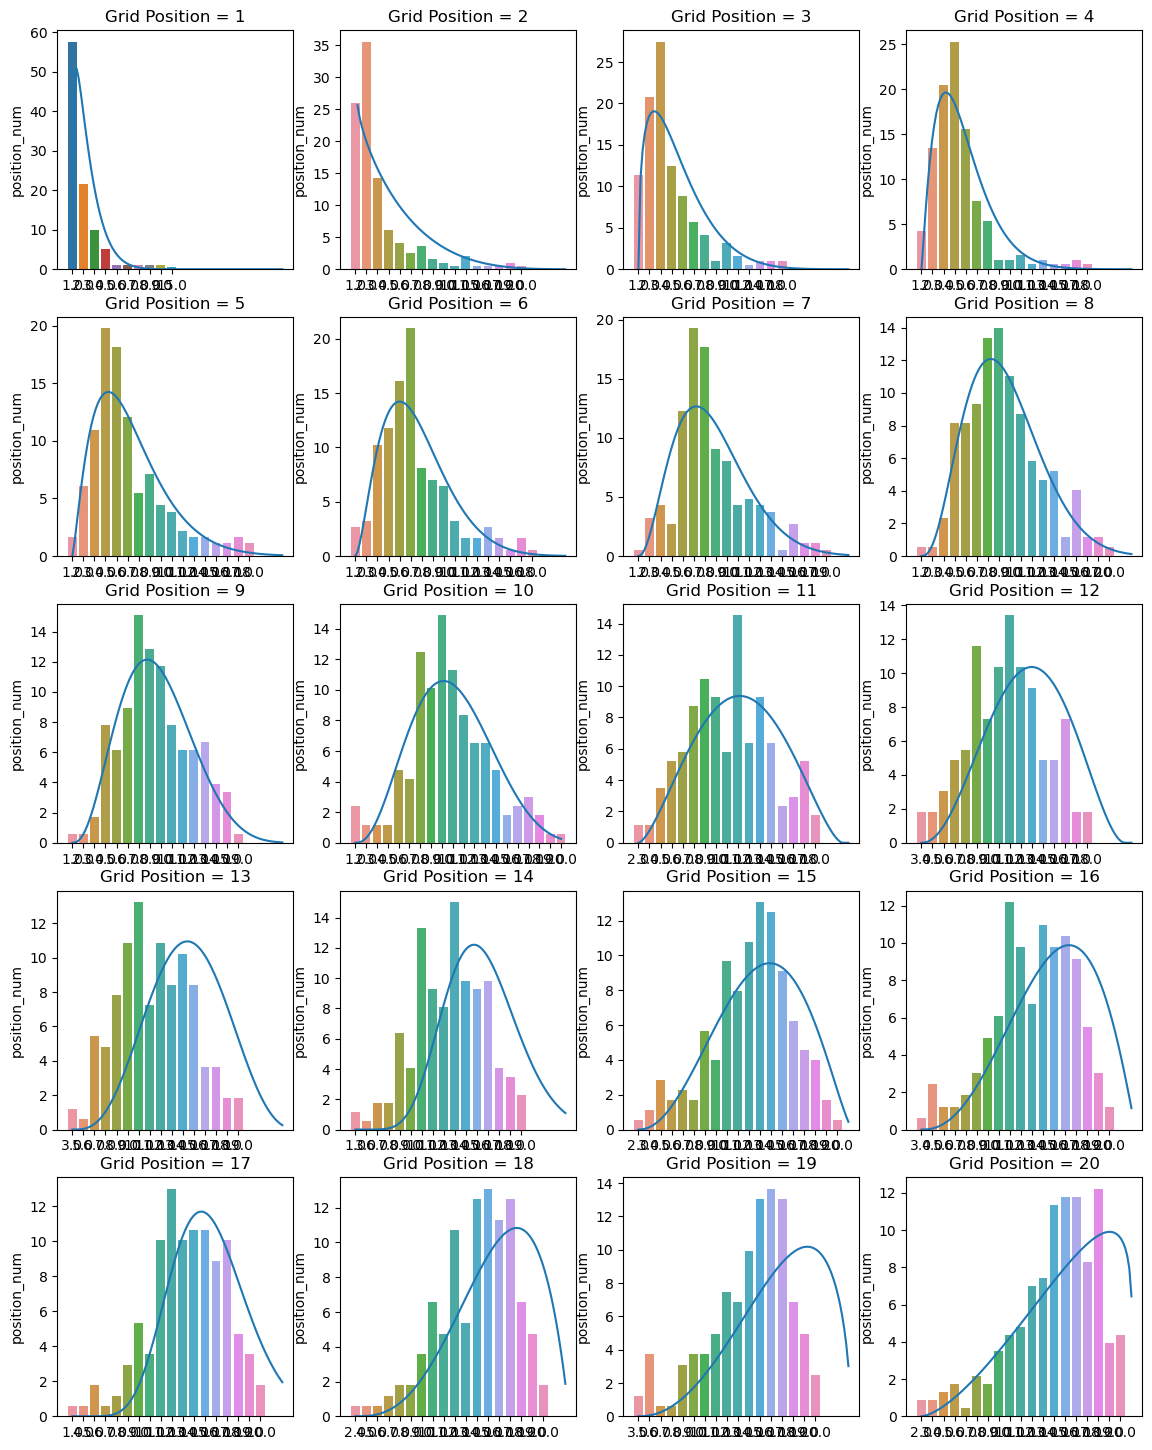

In [33]:
grid_positions = range(1, 21)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(14, 18), squeeze=False) 
axes = axes.flatten()

for grid_pos in grid_positions:
    race_counts = f1[f1['gridPosition'] == grid_pos]['position_num'].value_counts(normalize=True, dropna=True)
    sns.barplot(x=race_counts.index, y=race_counts*100, ax=axes[grid_pos-1])
    x = np.linspace(1, 20, 100)
    y = beta.pdf(x, a_list[grid_pos-1], b_list[grid_pos-1], 1, scale_list[grid_pos-1])
    axes[grid_pos-1].plot(x-1, y*100)
    axes[grid_pos-1].set_title('Grid Position = ' + str(grid_pos))
plt.show()

In [34]:
# create dataframe for storing beta fits
beta_df = pd.DataFrame({'a': a_list,
                       'b': b_list,
                       'scale': scale_list})

In [35]:
beta_df.to_csv('data/beta_fits.csv')